In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score 
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\04ama\Downloads\raw adhd data\raw_data.csv")
print(f"Original dataset shape: {df.shape}")


Original dataset shape: (1213, 19929)


In [14]:
def handedness_group(score):
    """Convert EHQ score to handedness category"""
    if pd.isna(score):
        return np.nan
    elif score <= -0.5:
        return 0.0  # Left
    elif score >= 0.5:
        return 2.0  # Right
    else:
        return 1.0  # Ambidextrous

# Create handedness groups
if 'EHQ_EHQ_Total' in df.columns:
    df['Handedness_Group'] = df['EHQ_EHQ_Total'].apply(handedness_group)

# Remove problematic columns
if 'MRI_Track_Age_at_Scan' in df.columns:
    df = df.drop(columns=['MRI_Track_Age_at_Scan'])

In [15]:
y = df['ADHD_Outcome']
X = df.drop(columns=['ADHD_Outcome', 'participant_id'], errors='ignore')

In [16]:
quant_cols = [col for col in df.columns if col.startswith('APQ_') or col.startswith('SDQ_') or col.startswith('EHQ_') or col.startswith('ColorVision')]
cat_cols = [col for col in df.columns if col.startswith('PreInt_') or col.startswith('Basic_') or col.startswith('Handedness')]
conn_cols = list(df.iloc[:, 1:19902].columns)

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [18]:
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()

In [19]:
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()

In [20]:
print("Scaling quantitative features...")
X_train_processed[quant_cols] = scaler.fit_transform(X_train_processed[quant_cols])
X_val_processed[quant_cols] = scaler.transform(X_val_processed[quant_cols])
X_test_processed[quant_cols] = scaler.transform(X_test_processed[quant_cols])

Scaling quantitative features...


In [21]:
all_feature_cols = quant_cols + cat_cols
X_train_processed[all_feature_cols] = imputer.fit_transform(X_train_processed[all_feature_cols])
X_val_processed[all_feature_cols] = imputer.transform(X_val_processed[all_feature_cols])
X_test_processed[all_feature_cols] = imputer.transform(X_test_processed[all_feature_cols])

In [29]:
print(f"Preprocessing complete!")
print(f"Features ready for SFS: {len(quant_cols)} quantitative + {len(cat_cols)} categorical = {len(all_feature_cols)} total")


Preprocessing complete!
Features ready for SFS: 17 quantitative + 5 categorical = 22 total


In [39]:


# Test different numbers of features
n_features_list = [5,10, 15, 20, 21]
sfs_results = {}

# Initialize base model for SFS
base_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

for n_features in n_features_list:
    print(f"\n{'='*50}")
    print(f"TESTING SFS WITH {n_features} FEATURES")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Initialize Sequential Feature Selector
    sfs = SequentialFeatureSelector(
        estimator=base_model,
        n_features_to_select=min(n_features, len(all_feature_cols)),
        direction='forward',
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        
    )
    
    print(f"Running forward selection on {len(all_feature_cols)} features...")
    print(f"Target: Select {min(n_features, len(all_feature_cols))} best features")
    
    # Fit SFS on training data (scaled quantitative + categorical)
    X_train_sfs = X_train_processed[all_feature_cols]
    sfs.fit(X_train_sfs, y_train)
    
    # Get selected features
    selected_mask = sfs.get_support()
    selected_features = [col for col, selected in zip(all_feature_cols, selected_mask) if selected]
    
    sfs_time = time.time() - start_time
    
    print(f"\nSFS completed in {sfs_time:.1f} seconds")
    print(f"Selected {len(selected_features)} features:")
    
    # Categorize selected features
    selected_quant = [f for f in selected_features if f in quant_cols]
    selected_cat = [f for f in selected_features if f in cat_cols]
    
    print(f"  - Quantitative: {len(selected_quant)}")
    print(f"  - Categorical: {len(selected_cat)}")
    
    print(f"\nTop selected features:")
    for i, feat in enumerate(selected_features[:15]):
        feat_type = "Quantitative" if feat in quant_cols else "Categorical"
        print(f"  {i+1:2d}. {feat} ({feat_type})")
    if len(selected_features) > 10:
        print(f"      ... and {len(selected_features) - 10} more")
    
   
    print(f"\n--- Cross-Validation Evaluation ---")
    
    # Prepare selected feature data
    X_train_selected = X_train_processed[selected_features]
    X_val_selected = X_val_processed[selected_features]
    X_test_selected = X_test_processed[selected_features]
    
    # Cross-validation F1 scores
    cv_f1_scores = cross_val_score(
        base_model, 
        X_train_selected, 
        y_train, 
        cv=5, 
        scoring='f1_macro',
        n_jobs=-1
    )
    
    mean_f1 = np.mean(cv_f1_scores)
    median_f1 = np.median(cv_f1_scores)
    std_f1 = np.std(cv_f1_scores)
    
    print(f"Cross-validation F1-Macro scores: {cv_f1_scores}")
    print(f"Mean F1-Macro: {mean_f1:.4f}")
    print(f"Median F1-Macro: {median_f1:.4f}")
    print(f"Std Dev F1-Macro: {std_f1:.4f}")
    
    # Train final model for validation/test evaluation
    final_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    final_model.fit(X_train_selected, y_train)
    
    # Validation set evaluation
    y_val_pred = final_model.predict(X_val_selected)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    
    # Test set evaluation
    y_test_pred = final_model.predict(X_test_selected)
    y_test_proba = final_model.predict_proba(X_test_selected)[:, 1]
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = auc(*roc_curve(y_test, y_test_proba)[:2])
    
    print(f"\nValidation F1-Macro: {val_report['macro avg']['f1-score']:.4f}")
    print(f"Test F1-Macro: {test_report['macro avg']['f1-score']:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Accuracy: {test_report['accuracy']:.4f}")
    print(f"ADHD Precision: {test_report['1']['precision']:.4f}")
    print(f"ADHD Recall: {test_report['1']['recall']:.4f}")
    
    # Store results
    sfs_results[n_features] = {
        'selected_features': selected_features,
        'selected_quant': selected_quant,
        'selected_cat': selected_cat,
        'cv_f1_scores': cv_f1_scores,
        'mean_f1': mean_f1,
        'median_f1': median_f1,
        'std_f1': std_f1,
        'val_f1': val_report['macro avg']['f1-score'],
        'test_f1': test_report['macro avg']['f1-score'],
        'test_auc': test_auc,
        'test_acc': test_report['accuracy'],
        'adhd_precision': test_report['1']['precision'],
        'adhd_recall': test_report['1']['recall'],
        'sfs_time': sfs_time
    }





TESTING SFS WITH 5 FEATURES
Running forward selection on 22 features...
Target: Select 5 best features

SFS completed in 6.3 seconds
Selected 5 features:
  - Quantitative: 4
  - Categorical: 1

Top selected features:
   1. ColorVision_CV_Score (Quantitative)
   2. APQ_P_APQ_P_OPD (Quantitative)
   3. SDQ_SDQ_Hyperactivity (Quantitative)
   4. SDQ_SDQ_Prosocial (Quantitative)
   5. Basic_Demos_Study_Site (Categorical)

--- Cross-Validation Evaluation ---
Cross-validation F1-Macro scores: [0.741854   0.75020129 0.76881378 0.76881378 0.80157895]
Mean F1-Macro: 0.7663
Median F1-Macro: 0.7688
Std Dev F1-Macro: 0.0206

Validation F1-Macro: 0.7685
Test F1-Macro: 0.7051
Test AUC: 0.7981
Test Accuracy: 0.7243
ADHD Precision: 0.8561
ADHD Recall: 0.7169

TESTING SFS WITH 10 FEATURES
Running forward selection on 22 features...
Target: Select 10 best features

SFS completed in 4.8 seconds
Selected 10 features:
  - Quantitative: 6
  - Categorical: 4

Top selected features:
   1. ColorVision_CV_Scor

In [34]:


comparison_data = []
for n_feat in n_features_list:
    results = sfs_results[n_feat]
    comparison_data.append({
        'N_Features': n_feat,
        'Selected_Features': len(results['selected_features']),
        'Quant_Features': len(results['selected_quant']),
        'Cat_Features': len(results['selected_cat']),
        'Mean_CV_F1': results['mean_f1'],
        'Median_CV_F1': results['median_f1'],
        'Std_CV_F1': results['std_f1'],
        'Val_F1': results['val_f1'],
        'Test_F1': results['test_f1'],
        'Test_AUC': results['test_auc'],
        'Test_Accuracy': results['test_acc'],
        'ADHD_Precision': results['adhd_precision'],
        'ADHD_Recall': results['adhd_recall'],
        'SFS_Time': results['sfs_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nSFS Performance Summary:")
print(comparison_df.round(4))




SFS Performance Summary:
   N_Features  Selected_Features  Quant_Features  Cat_Features  Mean_CV_F1  \
0           5                  5               4             1      0.7663   
1          10                 10               6             4      0.7632   
2          15                 15              11             4      0.7653   
3          20                 20              16             4      0.7583   
4          21                 21              17             4      0.7601   

   Median_CV_F1  Std_CV_F1  Val_F1  Test_F1  Test_AUC  Test_Accuracy  \
0        0.7688     0.0206  0.7685   0.7051    0.7981         0.7243   
1        0.7645     0.0124  0.7752   0.7051    0.7967         0.7243   
2        0.7732     0.0155  0.7738   0.7187    0.7969         0.7407   
3        0.7537     0.0138  0.7791   0.7150    0.7903         0.7366   
4        0.7601     0.0090  0.7699   0.7225    0.7878         0.7449   

   ADHD_Precision  ADHD_Recall  SFS_Time  
0          0.8561       0.716

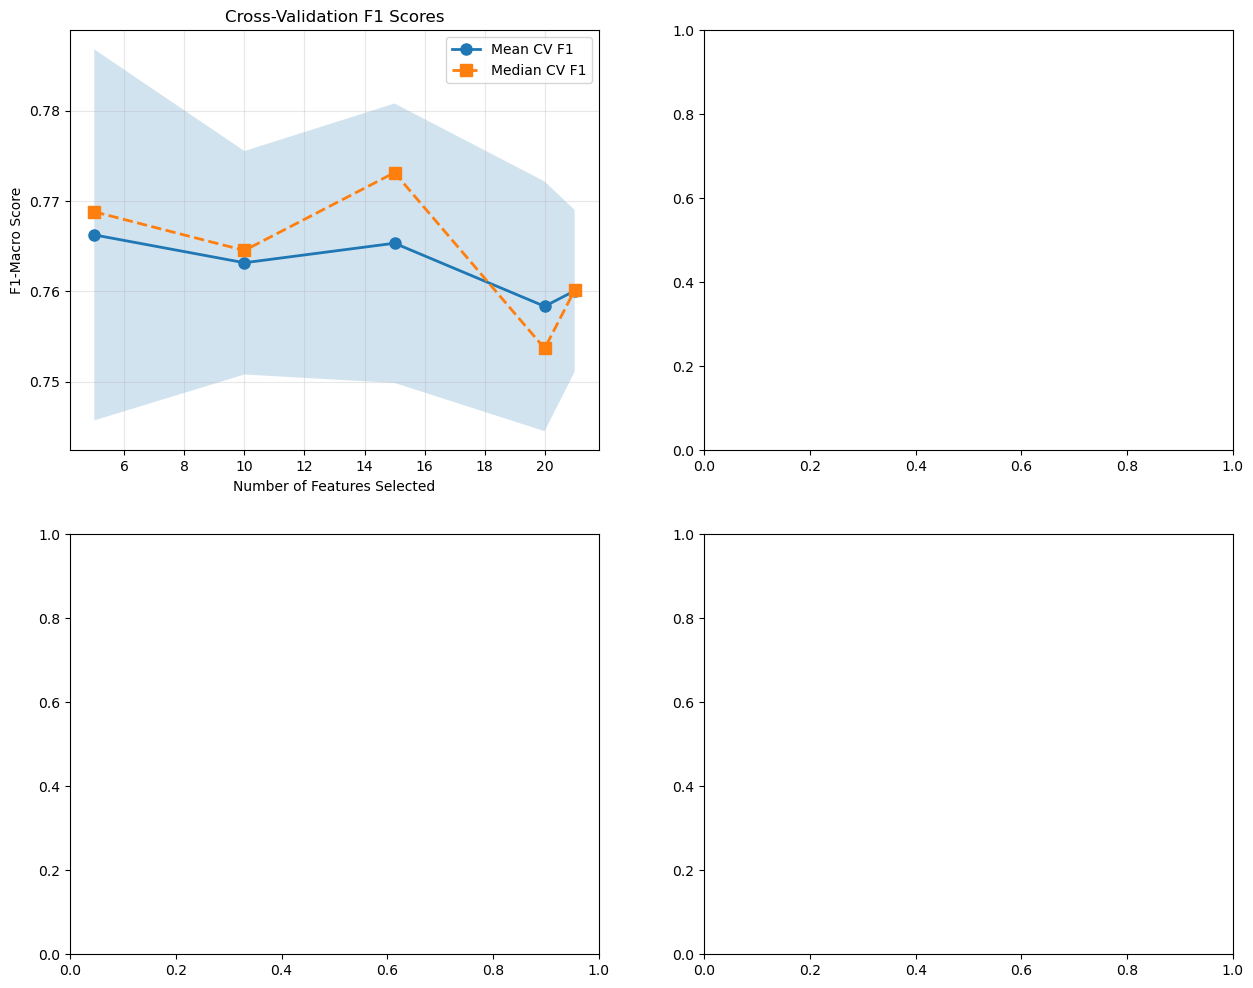

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cross-validation F1 scores
axes[0, 0].plot(comparison_df['N_Features'], comparison_df['Mean_CV_F1'], 'o-', label='Mean CV F1', linewidth=2, markersize=8)
axes[0, 0].plot(comparison_df['N_Features'], comparison_df['Median_CV_F1'], 's--', label='Median CV F1', linewidth=2, markersize=8)
axes[0, 0].fill_between(comparison_df['N_Features'], 
                       comparison_df['Mean_CV_F1'] - comparison_df['Std_CV_F1'],
                       comparison_df['Mean_CV_F1'] + comparison_df['Std_CV_F1'], 
                       alpha=0.2)
axes[0, 0].set_xlabel('Number of Features Selected')
axes[0, 0].set_ylabel('F1-Macro Score')
axes[0, 0].set_title('Cross-Validation F1 Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

In [38]:
best_n_features = comparison_df.loc[comparison_df['Test_F1'].idxmax(), 'N_Features']
best_results = sfs_results[best_n_features]

print(f"\nBEST CONFIGURATION: {best_n_features} features")
print(f"Cross-validation F1-Macro: {best_results['mean_f1']:.4f} ± {best_results['std_f1']:.4f}")
print(f"Test F1-Macro: {best_results['test_f1']:.4f}")
print(f"Test AUC: {best_results['test_auc']:.4f}")
print(f"ADHD Precision: {best_results['adhd_precision']:.4f}")
print(f"ADHD Recall: {best_results['adhd_recall']:.4f}")

print(f"\nBest selected features ({len(best_results['selected_features'])}):")
print(f"\nQuantitative features ({len(best_results['selected_quant'])}):")
for i, feat in enumerate(best_results['selected_quant']):
    print(f"  {i+1:2d}. {feat}")

print(f"\nCategorical features ({len(best_results['selected_cat'])}):")
for i, feat in enumerate(best_results['selected_cat']):
    print(f"  {i+1:2d}. {feat}")



BEST CONFIGURATION: 21 features
Cross-validation F1-Macro: 0.7601 ± 0.0090
Test F1-Macro: 0.7225
Test AUC: 0.7878
ADHD Precision: 0.8562
ADHD Recall: 0.7530

Best selected features (21):

Quantitative features (17):
   1. EHQ_EHQ_Total
   2. ColorVision_CV_Score
   3. APQ_P_APQ_P_CP
   4. APQ_P_APQ_P_ID
   5. APQ_P_APQ_P_INV
   6. APQ_P_APQ_P_OPD
   7. APQ_P_APQ_P_PM
   8. APQ_P_APQ_P_PP
   9. SDQ_SDQ_Conduct_Problems
  10. SDQ_SDQ_Difficulties_Total
  11. SDQ_SDQ_Emotional_Problems
  12. SDQ_SDQ_Externalizing
  13. SDQ_SDQ_Generating_Impact
  14. SDQ_SDQ_Hyperactivity
  15. SDQ_SDQ_Internalizing
  16. SDQ_SDQ_Peer_Problems
  17. SDQ_SDQ_Prosocial

Categorical features (4):
   1. Basic_Demos_Enroll_Year
   2. Basic_Demos_Study_Site
   3. PreInt_Demos_Fam_Child_Ethnicity
   4. Handedness_Group
